## Imports

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
import numpy as np

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, r'E:\GitHub\smart-parking-system')

from system.detection.model import deeplab_v3
from system.classification.model import CharacterClassifier
import system.backend.utils.utils as utils

## Constants

In [2]:
detection_model_path = r'E:\GitHub\smart-parking-system\system\detection\training\experiment_v0.02\model_checkpoints\v0.02_e59_l0.125.pt'
classification_model_path = r"E:/GitHub/smart-parking-system/system/classification/training/experiment_v0.14/model_checkpoints/v0.14_e9_l0.074.pt"

## Functions

In [3]:
def show_images(images, cols=1, prefix='Image ', titles=None):
    # https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = [f'{prefix} ({i})' for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(int(cols), int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [4]:
def plot(img, pred, threshold=0.1):
    plt.figure(figsize=(20,20));
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(torch.squeeze(pred).cpu().numpy()>threshold)
    plt.title('Segmentation Output')
    plt.axis('off')

In [5]:
def pred(image, model_segmentare):
    preprocess = transforms.Compose([
        #transforms.Resize((320, 640)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model_segmentare(input_batch)
        return output

In [6]:
def histogram_equalization(image: Image.Image):
    """
    Apply histogram equalization to a given image.
    :param image: An image.
    :return: The image after the histogram equalization as numpy array.
    """
    # Converting the image to grayscale if not in grayscale
    '''if not image.mode == 'L':
        print(f'Image mode is \"{image.mode}\". Converting to grayscale')
        image = image.convert('L')'''

    # Convert the image to an array to be used by skimage equalization function
    image = np.array(image)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)

    return equalized

## License plate detection

### Load model into memory

In [7]:
model_segmentare = deeplab_v3('resnet101', 'imagenet', ['license-plate'], 'sigmoid')
checkpoint = torch.load(detection_model_path, map_location='cpu')
model_segmentare.load_state_dict(checkpoint)
model_segmentare.eval()

if torch.cuda.is_available():
    model_segmentare.to('cuda')

### Read sample and predict license plate location

In [8]:
#input_sample = Image.open(r"E:\GitHub\smart-parking-system\dataset\segmentation\test\images\lpdr_sample_364.jpg").convert('RGB')
input_sample = Image.open(r"E:\GitHub\smart-parking-system\inputs\sample_v3.png").convert('RGB')

In [9]:
input_sample = input_sample.resize((640,320)) # The size required by the model, used for training

preprocess = transforms.Compose([
        transforms.ToTensor(),
    ])

input_tensor = preprocess(input_sample)
input_batch = input_tensor.unsqueeze(0)
    
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

with torch.no_grad():
    output = model_segmentare(input_batch)

### Crop the license plate from the entire input image

In [10]:
# Convert from tensor to grayscale numpy array
mask = torch.squeeze(output).cpu().numpy()>0.7
mask_grayscale = np.array(Image.fromarray(mask).convert("L"))

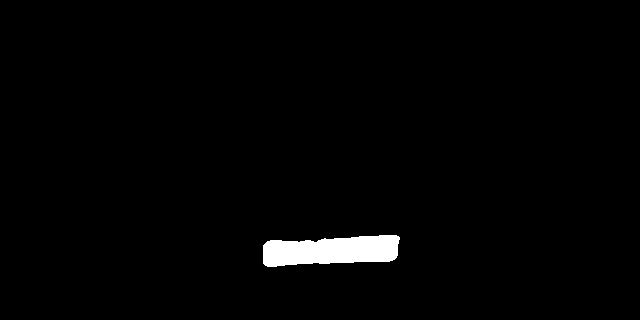

In [11]:
display(Image.fromarray(mask_grayscale))

In [12]:
# Do contour detection to find the biggest bounding box in the predict
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(mask_grayscale, kernel, iterations=1)

_, threshold = cv2.threshold(img_dilation, 127, 255, cv2.THRESH_TOZERO)
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(cnt) for cnt in contours]
max_area_idx = np.argmax(areas)
x, y = contours[max_area_idx].T
plate_bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))

In [13]:
plate_result = np.array(input_sample)
plate_result = plate_result[max(plate_bbox[0][1], 0) : min(plate_bbox[1][1], plate_result.shape[0]),max(plate_bbox[0][0], 0) : min(plate_bbox[1][0], plate_result.shape[1])]

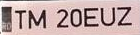

In [14]:
display(Image.fromarray(plate_result))

In [15]:
plate_result = utils.image_resize(plate_result, height=256)
plate_result = utils.unsharp_mask(plate_result, amount=50)

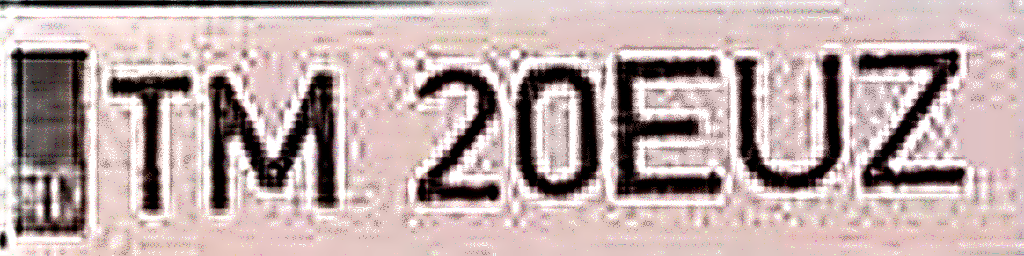

In [16]:
display(Image.fromarray(plate_result))

## Character segmentation using bounding boxes

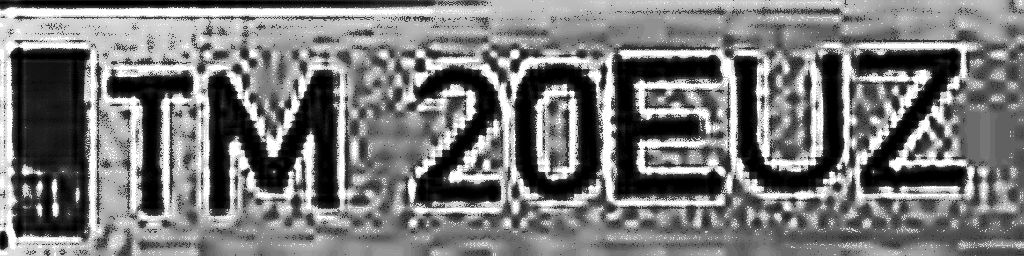

In [17]:
# Do some preprocessing on the license plate
histogram_eq_image = histogram_equalization(plate_result)
display(Image.fromarray(histogram_eq_image))

In [99]:
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(histogram_eq_image, kernel, iterations=1)

_, threshold = cv2.threshold(img_dilation, 75, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)

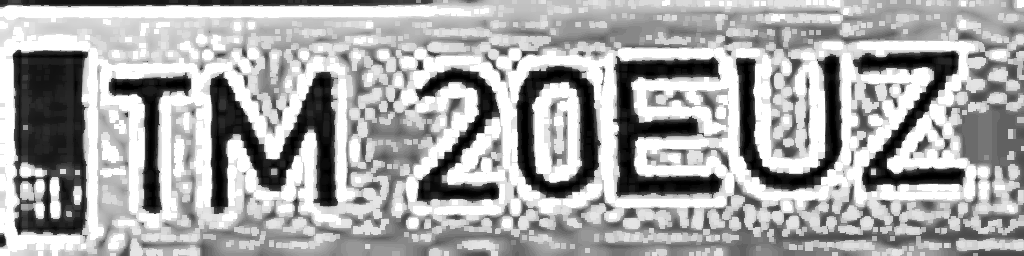

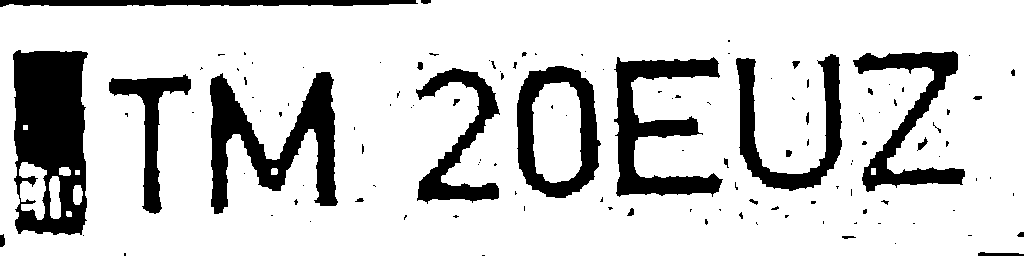

In [100]:
display(Image.fromarray(img_dilation))
display(Image.fromarray(threshold))

In [73]:
areas = [cv2.contourArea(cnt) for cnt in contours]
max_area_idx = np.argmax(areas)
x, y = contours[max_area_idx].T
new_plate_bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))

In [74]:
cropped_plate_without_noise = threshold[max(new_plate_bbox[0][1], 0) : min(new_plate_bbox[1][1], threshold.shape[0]),
                                        max(new_plate_bbox[0][0], 0) : min(new_plate_bbox[1][0], threshold.shape[1])]

In [75]:
cropped_plate_without_noise_rgb = cv2.cvtColor(cropped_plate_without_noise,cv2.COLOR_GRAY2RGB) # This is not necessarry in the backend, just for debugging purposes

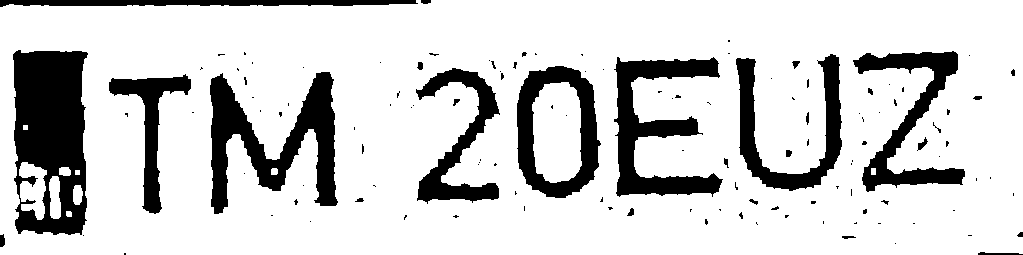

In [76]:
display(Image.fromarray(cropped_plate_without_noise))

In [77]:
contours, _ = cv2.findContours(cropped_plate_without_noise, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)
areas = [cv2.contourArea(cnt) for cnt in contours]
max_area_idx = np.argmax(areas)

In [78]:
letters_bboxes = [areas.index(x) for x in sorted(areas, reverse=True)[:14]]
letters_bboxes.remove(max_area_idx)
print(f'letters_bboxes after removal is : {letters_bboxes}')

letters_bboxes after removal is : [133, 109, 98, 121, 131, 123, 110, 105, 96, 139, 136, 135, 138]


In [79]:
for idxs in letters_bboxes:
    x, y = contours[idxs].T
    bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))
    backtorgb = cv2.rectangle(cropped_plate_without_noise_rgb, bbox[0], bbox[1], (255, 0, 0), 1)

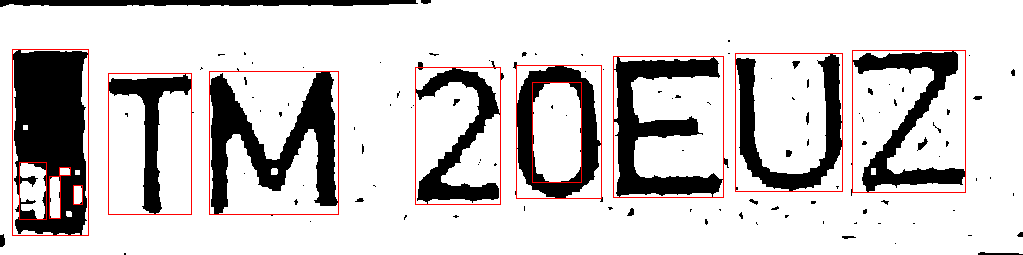

In [80]:
display(Image.fromarray(cropped_plate_without_noise_rgb))

idxs = 133
 values = array([  0, 255], dtype=uint8)
 counts = array([10598,  3538], dtype=int64)
idxs = 109
 values = array([  0, 255], dtype=uint8)
 counts = array([4788, 6517], dtype=int64)


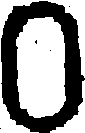

area = 293771
idxs = 98
 values = array([  0, 255], dtype=uint8)
 counts = array([ 7619, 10828], dtype=int64)


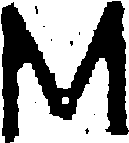

area = 155895
idxs = 121
 values = array([  0, 255], dtype=uint8)
 counts = array([6213, 9297], dtype=int64)


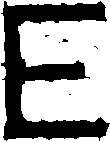

area = 338008
idxs = 131
 values = array([  0, 255], dtype=uint8)
 counts = array([ 4889, 11157], dtype=int64)


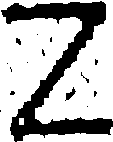

area = 439714
idxs = 123
 values = array([  0, 255], dtype=uint8)
 counts = array([ 4667, 10099], dtype=int64)


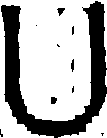

area = 384788
idxs = 110
 values = array([  0, 255], dtype=uint8)
 counts = array([ 625, 4275], dtype=int64)
idxs = 105
 values = array([  0, 255], dtype=uint8)
 counts = array([3860, 7785], dtype=int64)


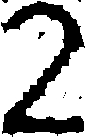

area = 247965
idxs = 96
 values = array([  0, 255], dtype=uint8)
 counts = array([2956, 8747], dtype=int64)


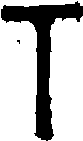

area = 85813
idxs = 139
 values = array([  0, 255], dtype=uint8)
 counts = array([ 480, 1059], dtype=int64)
idxs = 136
 values = array([  0, 255], dtype=uint8)
 counts = array([ 56, 406], dtype=int64)
idxs = 135
 values = array([  0, 255], dtype=uint8)
 counts = array([ 13, 158], dtype=int64)
idxs = 138
 values = array([  0, 255], dtype=uint8)
 counts = array([ 4, 84], dtype=int64)


In [81]:
filtered_bboxes = []
for idxs in letters_bboxes:
    print(f'{idxs = }')
    x, y = contours[idxs].T
    bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))
    character = cropped_plate_without_noise[max(bbox[0][1], 0) : min(bbox[1][1], cropped_plate_without_noise.shape[0]), 
                                     max(bbox[0][0], 0) : min(bbox[1][0], cropped_plate_without_noise.shape[1])]
    
    _, thresholded_character = cv2.threshold(character, 127, 255, cv2.THRESH_BINARY)
    values, counts = np.unique(thresholded_character, return_counts=True)
    print(f' {values = }')
    print(f' {counts = }')
    if counts[0] > 2000 and counts[1] > (counts[0] / 2) and len(counts) > 1:
        display(Image.fromarray(character))
        print(f'area = {(max(bbox[0][1], 0) + min(bbox[1][1], cropped_plate_without_noise.shape[0])) * (max(bbox[0][0], 0) + min(bbox[1][0], cropped_plate_without_noise.shape[1]))}')
        filtered_bboxes.append(bbox)

In [82]:
x, y = contours[26].T
bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))
character = cropped_plate_without_noise[max(bbox[0][1]-5, 0) : min(bbox[1][1]+5, cropped_plate_without_noise.shape[0]), 
                                     max(bbox[0][0]-5, 0) : min(bbox[1][0]+5, cropped_plate_without_noise.shape[1])]
display(Image.fromarray(character))
_, thresholded_character = cv2.threshold(character, 127, 255, cv2.THRESH_BINARY)
display(Image.fromarray(thresholded_character))
values, counts = np.unique(thresholded_character, return_counts=True)
values, counts

(array([  0, 255], dtype=uint8), array([ 14, 210], dtype=int64))

In [83]:
areas[12]

20.5

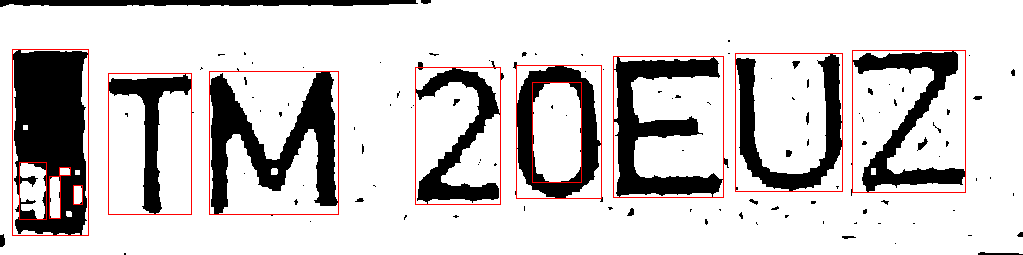

In [84]:
display(Image.fromarray(cropped_plate_without_noise_rgb))

In [85]:
filtered_bboxes[0][0]

(516, 65)

In [86]:
cropped_plate_without_noise_rgb = cv2.circle(cropped_plate_without_noise_rgb, filtered_bboxes[0][0], radius=3, color=(0, 255, 255), thickness=-1)

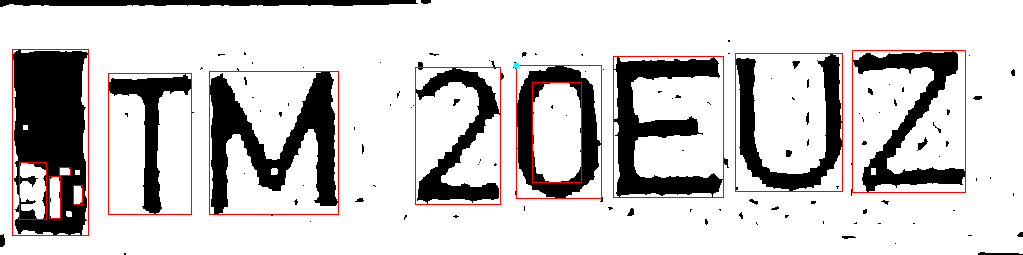

In [87]:
display(Image.fromarray(cropped_plate_without_noise_rgb))

In [88]:
filtered_bboxes

[((516, 65), (601, 198)),
 ((209, 71), (338, 214)),
 ((613, 56), (723, 197)),
 ((852, 50), (965, 192)),
 ((735, 53), (842, 191)),
 ((415, 67), (500, 204)),
 ((108, 73), (191, 214))]

In [89]:
filtered_bboxes = sorted(filtered_bboxes, key=lambda x: x[0][0])

In [90]:
filtered_bboxes

[((108, 73), (191, 214)),
 ((209, 71), (338, 214)),
 ((415, 67), (500, 204)),
 ((516, 65), (601, 198)),
 ((613, 56), (723, 197)),
 ((735, 53), (842, 191)),
 ((852, 50), (965, 192))]

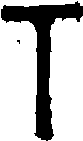

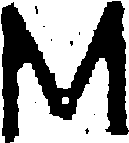

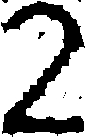

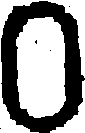

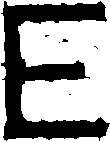

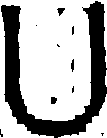

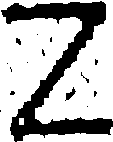

In [91]:
for bbox in filtered_bboxes:
    display(Image.fromarray(cropped_plate_without_noise[max(bbox[0][1], 0) : min(bbox[1][1], cropped_plate_without_noise.shape[0]), 
                                     max(bbox[0][0], 0) : min(bbox[1][0], cropped_plate_without_noise.shape[1])]))

## Character classification based on bounding boxes

In [92]:
model_classificare = CharacterClassifier().to("cuda")
model_classificare.load_state_dict(torch.load(classification_model_path))
model_classificare.eval()

CharacterClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=196608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=35, bias=True)
)

In [93]:
raw_max_size = [195, 256]

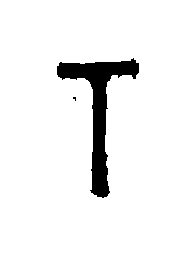

tensor([[-11.9538, -13.1886, -20.8823, -12.8803, -21.3279, -10.3565, -31.1843,
           2.5199, -24.5938, -18.7134, -36.3939, -32.6897,  -7.8883, -20.8473,
         -16.0520, -13.6142, -19.8094, -38.1633, -21.8612, -20.9500, -26.9897,
         -21.6358, -37.0314, -24.5014, -10.4655, -20.7873, -22.8687,  -3.7930,
          20.9412, -31.1563, -10.8708, -35.3177, -17.9909,  -1.9786, -11.1754]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([28])


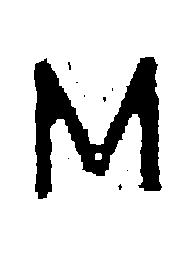

tensor([[-14.8103, -45.5415, -58.2400, -51.0922, -22.5377, -50.2263, -31.2235,
         -24.6895, -24.2634, -14.3967, -22.4446,   3.2495, -75.6392, -27.8145,
         -39.9694, -22.1719, -11.6015,   1.3798, -39.3555, -32.2880,   1.7072,
         -41.0779,  23.5043,   8.2707, -26.2360,  -2.1472,   0.1020, -40.2716,
         -68.4278,   7.3480,  -5.6341,   6.1778, -30.6258,  -4.3721, -34.1559]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([22])


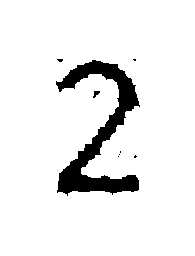

tensor([[-13.0084, -19.7954,  23.4616,   3.4359, -26.3673, -37.4722, -49.7785,
           3.1127, -16.7401,  -8.7462, -22.9829, -20.5592, -26.2517, -12.4206,
         -20.8975, -22.4727, -18.9801, -56.8352, -37.8457, -15.3578, -42.1044,
         -47.4020, -31.5304, -47.5846, -13.7011, -22.0578, -21.5093, -16.9527,
         -13.7070, -36.2397, -14.2684, -40.0880,  -7.9014, -24.2510,  -1.9451]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([2])


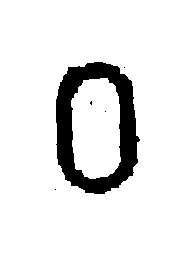

tensor([[ 14.3516,  -9.0211, -11.8359, -28.1939, -14.8234, -24.1956,  -9.4154,
         -22.1044,  -4.5332,  -8.4063, -20.8075,  -5.3341, -13.1349,  -4.6120,
         -23.0854, -27.1622,  -7.1364, -28.6601, -15.6009, -24.0869, -46.8246,
         -23.1745, -26.6674, -12.8525,  -2.4081, -14.2436, -15.7812, -26.5230,
         -22.4439, -17.3936, -16.6673, -33.7496, -38.0996, -38.4447, -28.0610]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0])


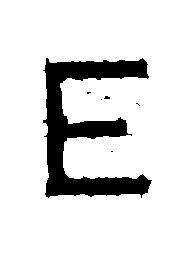

tensor([[-40.6249, -83.5811, -38.4379, -30.5094, -12.7607,  -9.2856,  -4.7823,
         -50.1156, -30.4808, -38.4154, -18.0359,  -3.0991, -26.5318, -11.1995,
          22.4780,   2.9110, -22.6066, -15.6154, -31.1276, -36.1084, -19.1543,
          -4.5950, -46.5282, -21.0111, -62.0973, -41.7262, -24.6923,  -4.7809,
         -35.1382, -36.6788, -32.9652, -35.8783, -21.4908, -49.7943,  -8.4115]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([14])


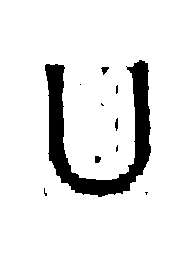

tensor([[ -2.0038, -26.3281, -22.5789, -20.1254, -26.1066, -48.7193, -35.6540,
         -32.9888, -27.2366, -29.6819, -24.9165,  -1.2103, -37.2343,   9.6207,
         -37.8234, -41.8913, -20.0077, -10.0991, -21.2705,   4.3342, -33.4417,
         -10.0292, -14.8358,  -6.4365,  -6.8111, -25.1172, -30.5139, -38.7574,
         -53.8564,  15.0464,  -0.5823, -19.4801, -39.0136, -36.4461, -20.5780]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([29])


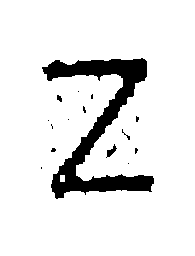

tensor([[-27.4063, -37.6017,   8.8053,   7.0730, -16.5523, -37.9628, -44.0748,
          -0.8815, -32.7451, -37.8984, -16.6354, -35.7291, -18.4162, -13.3491,
         -22.2072, -20.4348, -35.5679, -54.9119, -34.7226,  -2.6384, -25.9382,
         -30.1181, -31.1523, -48.2944, -39.3611, -45.7283, -41.6672,  -9.1548,
         -14.2989, -37.4102,  -7.9834, -35.4150,  11.6453, -21.9804,  19.0014]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([34])


In [94]:
license_plate_predicts_list = []
for bbox in filtered_bboxes:
    character = Image.fromarray(cropped_plate_without_noise[max(bbox[0][1], 0) : min(bbox[1][1], cropped_plate_without_noise.shape[0]), 
                                            max(bbox[0][0], 0) : min(bbox[1][0], cropped_plate_without_noise.shape[1])])
    width, height = character.size

    x_axis_offset = (raw_max_size[0] - width) / 2
    y_axis_offset = (raw_max_size[1] - height) / 2
    new_width = width + int((2 * x_axis_offset))
    new_height = height + int((2 * y_axis_offset))

    result = Image.new(character.mode, (new_width, new_height), 255)
    result.paste(character, (int(x_axis_offset), int(y_axis_offset)))
    display(result)
    transform = transforms.Compose([transforms.ToTensor()])
    
    result = transform(result)
    result = result.unsqueeze(0)
    prediction = model_classificare(result.cuda())
    print(prediction)
    print(torch.argmax(prediction.cpu(), axis=1))
    license_plate_predicts_list.append(torch.argmax(prediction.cpu(), axis=1))

## License plate reconstruction as string

In [95]:
characters_mapping = {"0": 0,
                      "1": 1,
                      "2": 2,
                      "3": 3,
                      "4": 4,
                      "5": 5,
                      "6": 6,
                      "7": 7,
                      "8": 8,
                      "9": 9,
                      "10": "A",
                      "11": "B",
                      "12": "C",
                      "13": "D",
                      "14": "E",
                      "15": "F",
                      "16": "G",
                      "17": "H",
                      "18": "I",
                      "19": "J",
                      "20": "K",
                      "21": "L",
                      "22": "M",
                      "23": "N",
                      "24": "O",
                      "25": "P",
                      "26": "R",
                      "27": "S",
                      "28": "T",
                      "29": "U",
                      "30": "V",
                      "31": "W",
                      "32": "X",
                      "33": "Y",
                      "34": "Z"}
                    
                      

In [96]:
int(license_plate_predicts_list[0][0])

28

In [97]:
license_plate_as_string = []
for character in license_plate_predicts_list:
    license_plate_as_string.append(characters_mapping[str(int(character[0]))])

In [98]:
license_plate_as_string

['T', 'M', 2, 0, 'E', 'U', 'Z']

In [66]:
type(license_plate_predicts_list[0])

torch.Tensor